In [1]:
import json
import boto3
import sagemaker
from sagemaker.pytorch import PyTorch

sagemaker_session = sagemaker.Session()

bucket = 's3://chest-xrays'

role = 'arn:aws:iam::578203129999:role/service-role/AmazonSageMaker-ExecutionRole-20200419T032205'  

estimator = PyTorch(
    entry_point='train.py',
    source_dir='train',
    role=role,
    framework_version='1.4.0',
    py_version='py3',
    instance_count=1,
    instance_type='ml.p2.xlarge',
    hyperparameters={
        'epochs': 25,
        'batch-size': 1
    }
)

estimator.fit({
    'training': bucket+'/train'
})

2021-04-24 05:21:21 Starting - Starting the training job...
2021-04-24 05:21:46 Starting - Launching requested ML instancesProfilerReport-1619241680: InProgress
......
2021-04-24 05:22:46 Starting - Preparing the instances for training............
2021-04-24 05:24:47 Downloading - Downloading input data.........
2021-04-24 05:26:07 Training - Downloading the training image......
2021-04-24 05:27:18 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2021-04-24 05:27:20,288 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2021-04-24 05:27:20,316 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2021-04-24 05:27:20,530 sagemaker_pytorch_container.training INFO     Invoking user training script.
2021-04-24 05:27:21,107 sagemaker-containers INFO     Module default_user_module_name does not 

In [2]:
predictor = estimator.deploy(initial_instance_count = 1, instance_type = 'ml.m4.xlarge')

-------------!

In [3]:
predictor.endpoint

The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


'pytorch-training-2021-04-24-13-16-20-598'

In [4]:
import torch
import urllib
import numpy as np
from PIL import Image
from torchvision import datasets
from torchvision import transforms as T

normal_01 = urllib.request.urlopen('https://github.com/Supearnesh/ml-chestxray-cnn/raw/main/chestXrays/test/normal/IM-0033-0001-0001.jpeg')
normal_02 = urllib.request.urlopen('https://github.com/Supearnesh/ml-chestxray-cnn/raw/main/chestXrays/test/normal/IM-0006-0001.jpeg')
pneumonia_01 = urllib.request.urlopen('https://github.com/Supearnesh/ml-chestxray-cnn/raw/main/chestXrays/test/pneumonia/person100_bacteria_475.jpeg')

img = Image.open(normal_01).convert('RGB')

transform = T.Compose([T.Resize(112),
                       T.Resize((112, 160)),
                       T.ToTensor(),
                       T.Normalize(mean=(0.4954160,),
                                   std=(0.0564721,))])

normalized_img = transform(img)

tensor_img = normalized_img.unsqueeze(0)

prediction = predictor.predict(tensor_img)

tensor_prediction = np.argmax(prediction)

print(tensor_prediction)

1


In [5]:
from glob import glob

train_normal = np.array(glob('chestXrays/train/normal/*'))
train_pneumonia = np.array(glob('chestXrays/train/pneumonia/*'))

normal_sum = 0
pneumonia_sum = 0

for img in test_normal:
    img_open = Image.open(img).convert('RGB')

    transform = T.Compose([T.Resize(112),
                           T.Resize((112, 160)),
                           T.ToTensor(),
                           T.Normalize(mean=(0.4954160,),
                                       std=(0.0564721,))])

    normalized_img = transform(img_open)

    tensor_img = normalized_img.unsqueeze(0)

    prediction = predictor.predict(tensor_img)

    tensor_prediction = np.argmax(prediction)

    #predicted_class_index = int(np.squeeze(tensor_prediction.numpy()))

    normal_sum+=tensor_prediction

print('normal_sum: {}'.format(normal_sum))

for img in test_pneumonia:
    img_open = Image.open(img).convert('RGB')

    transform = T.Compose([T.Resize(112),
                           T.Resize((112, 160)),
                           T.ToTensor(),
                           T.Normalize(mean=(0.4954160,),
                                       std=(0.0564721,))])

    normalized_img = transform(img_open)

    tensor_img = normalized_img.unsqueeze(0)

    prediction = predictor.predict(tensor_img)

    tensor_prediction = np.argmax(prediction)

    pneumonia_sum+=tensor_prediction

print('pneumonia_sum: {}'.format(pneumonia_sum))

normal_sum: 77
pneumonia_sum: 3592


In [6]:
print('train precision: {}'.format(3592/(3592+77)))
print('train recall: {}'.format(3592/(3592+8)))

train precision: 0.9790133551376397
train recall: 0.9977777777777778


In [7]:
from glob import glob

test_normal = np.array(glob('chestXrays/test/normal/*'))
test_pneumonia = np.array(glob('chestXrays/test/pneumonia/*'))

normal_sum = 0
pneumonia_sum = 0

for img in test_normal:
    img_open = Image.open(img).convert('RGB')

    transform = T.Compose([T.Resize(112),
                           T.Resize((112, 160)),
                           T.ToTensor(),
                           T.Normalize(mean=(0.4954160,),
                                       std=(0.0564721,))])

    normalized_img = transform(img_open)

    tensor_img = normalized_img.unsqueeze(0)

    prediction = predictor.predict(tensor_img)

    tensor_prediction = np.argmax(prediction)

    normal_sum+=tensor_prediction

print('normal_sum: {}'.format(normal_sum))

for img in test_pneumonia:
    img_open = Image.open(img).convert('RGB')

    transform = T.Compose([T.Resize(112),
                           T.Resize((112, 160)),
                           T.ToTensor(),
                           T.Normalize(mean=(0.4954160,),
                                       std=(0.0564721,))])

    normalized_img = transform(img_open)

    tensor_img = normalized_img.unsqueeze(0)

    prediction = predictor.predict(tensor_img)

    tensor_prediction = np.argmax(prediction)

    pneumonia_sum+=tensor_prediction

print('pneumonia_sum: {}'.format(pneumonia_sum))

normal_sum: 169
pneumonia_sum: 388


In [8]:
print('test precision: {}'.format(388/(388+169)))
print('test recall: {}'.format(388/(388+2)))

test precision: 0.696588868940754
test recall: 0.9948717948717949


In [9]:
class_names = ['normal', 'pneumonia']

def predict_chest_xray(img_path):
    
    img = Image.open(img_path)
    
    print('img: {}'.format(img_path))
    
    plt.imshow(img)
    plt.show()

    converted_img = img.convert('RGB')

    transform = T.Compose([T.Resize(112),
                           T.Resize((112, 160)),
                           T.ToTensor(),
                           T.Normalize(mean=(0.4954160,),
                                       std=(0.0564721,))])

    normalized_img = transform(converted_img)

    tensor_img = normalized_img.unsqueeze(0)

    prediction = predictor.predict(tensor_img)

    tensor_prediction = np.argmax(prediction)
    
    print('model prediction: {}'.format(class_names[tensor_prediction]))

img: chestXrays/test/normal/NORMAL2-IM-0035-0001.jpeg


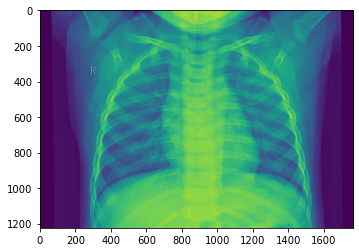

model prediction: normal


In [10]:
predict_chest_xray(test_normal[2])

img: chestXrays/test/pneumonia/person65_virus_123.jpeg


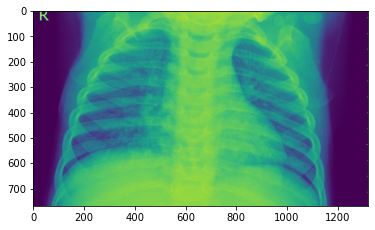

model prediction: pneumonia


In [11]:
predict_chest_xray(test_pneumonia[2])